Step 1: Train/Test Split

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.load("data/5_less_tensor.npz")
X = data["inputs"]
Y = data["outputs"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

Step 2: CNN Architecture (Pytorch)

In [2]:
import torch
import torch.nn as nn

class ChessMoveCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 2, kernel_size=1)  # 2 channels: start and end square
        )

    def forward(self, x):
        return self.net(x)

Step 3: Loss Function and Training Setup

In [3]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ChessMoveCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cuda


Step 4: Training Loop

In [4]:
from tqdm.auto import tqdm

train_losses = []
test_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        pbar.set_postfix(batch_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

/home/deanzhou/Desktop/Endplay/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/10: 100%|██████████| 86/86 [00:00<00:00, 209.79it/s, batch_loss=0.355]


Epoch 1/10 - Train Loss: 0.5452 - Test Loss: 0.3470


Epoch 2/10: 100%|██████████| 86/86 [00:00<00:00, 550.49it/s, batch_loss=0.0959]


Epoch 2/10 - Train Loss: 0.1907 - Test Loss: 0.0986


Epoch 3/10: 100%|██████████| 86/86 [00:00<00:00, 635.78it/s, batch_loss=0.0558]


Epoch 3/10 - Train Loss: 0.0709 - Test Loss: 0.0568


Epoch 4/10: 100%|██████████| 86/86 [00:00<00:00, 533.62it/s, batch_loss=0.0448]


Epoch 4/10 - Train Loss: 0.0494 - Test Loss: 0.0472


Epoch 5/10: 100%|██████████| 86/86 [00:00<00:00, 386.06it/s, batch_loss=0.0412]


Epoch 5/10 - Train Loss: 0.0422 - Test Loss: 0.0429


Epoch 6/10: 100%|██████████| 86/86 [00:00<00:00, 580.50it/s, batch_loss=0.0384]


Epoch 6/10 - Train Loss: 0.0389 - Test Loss: 0.0407


Epoch 7/10: 100%|██████████| 86/86 [00:00<00:00, 505.18it/s, batch_loss=0.0362]


Epoch 7/10 - Train Loss: 0.0367 - Test Loss: 0.0404


Epoch 8/10: 100%|██████████| 86/86 [00:00<00:00, 561.89it/s, batch_loss=0.0357]


Epoch 8/10 - Train Loss: 0.0354 - Test Loss: 0.0392


Epoch 9/10: 100%|██████████| 86/86 [00:00<00:00, 554.22it/s, batch_loss=0.0339]


Epoch 9/10 - Train Loss: 0.0347 - Test Loss: 0.0390


Epoch 10/10: 100%|██████████| 86/86 [00:00<00:00, 612.72it/s, batch_loss=0.0358]


Epoch 10/10 - Train Loss: 0.0338 - Test Loss: 0.0382


Step 5: Loss Plotting and Test Case Visualization

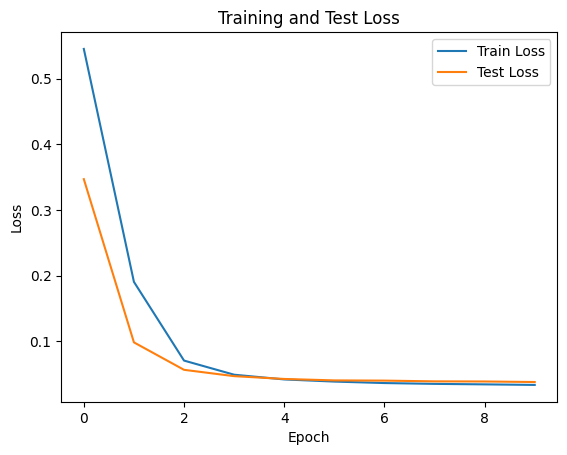

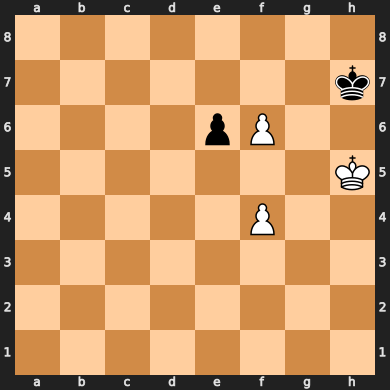

Top 5 predicted moves (start, end, uci, score):
h2g1: 0.1208
h2h1: 0.0577
h2g3: 0.0535
h2f5: 0.0345
e3g1: 0.0202


In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()

import utils
import chess

def get_top_5_moves(pred_tensor):
    pred = torch.sigmoid(pred_tensor).detach().cpu().numpy()  # shape (2, 8, 8)
    start_flat = pred[0].flatten()
    end_flat = pred[1].flatten()
    
    moves = []
    for start in range(64):
        for end in range(64):
            score = start_flat[start] * end_flat[end]
            moves.append((score, start, end))

    top5 = sorted(moves, key=lambda x: -x[0])[:5]
    return [(chess.square_name(s), chess.square_name(e), f"{chess.square_name(s)}{chess.square_name(e)}", float(score)) for score, s, e in top5]

# Pick a test sample
idx = np.random.randint(len(X_test))
x = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(device)
y_pred = model(x)[0]  # shape: (2, 8, 8)

board = utils.tensor_to_board(X_test[idx])
display(board)
top5_moves = get_top_5_moves(y_pred)

print("Top 5 predicted moves (start, end, uci, score):")
for start, end, uci, score in top5_moves:
    print(f"{uci}: {score:.4f}")